<a href="https://colab.research.google.com/github/eva7wandb/Eva7_Weights_Heist/blob/main/S12/STN_CIFAR10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/eva7wandb/Weights_Heist_Flow.git

fatal: destination path 'Weights_Heist_Flow' already exists and is not an empty directory.


In [3]:
! pip install albumentations==1.1.0
! pip install torchcam
! pip install torch-lr-finder

     |████████████████████████████████| 102 kB 7.1 MB/s 
     |████████████████████████████████| 47.6 MB 97 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.4.6
    Uninstalling albumentations-0.4.6:
      Successfully uninstalled albumentations-0.4.6


In [4]:
import sys
sys.path.append('./Weights_Heist_Flow/')

In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(True),
            nn.Linear(256, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 128 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
from main import Trainer, show_loss_curves

[INFO] seed set 1
[INFO] Cuda Avaliable :  True
[INFO] device :  cuda


In [9]:
trainer = Trainer(
    Net(), lr=0.001, batch_size=32, 
    scheduler=None,
    optimizer='SGD'
)

[INFO] Loading Dataset -- CIFAR10


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
[INFO] train dataset of size 50000 loaded...
Files already downloaded and verified
[INFO] test dataset of size 10000 loaded...
Files already downloaded and verified
[INFO] test dataset of size 10000 loaded...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]           9,472
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4            [-1, 128, 9, 9]         204,928
         MaxPool2d-5            [-1, 128, 4, 4]               0
              ReLU-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 256]         524,544
              ReLU-8                  [-1, 256]               0
            Linear-9                    [-1, 6]           1,542
           Conv2d-10           [-1,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


TEST         Loss:2.3084         Acc:9.64         [964 / 10000]


In [ ]:
trainer.train_model(epochs=50, log_stn_visuals=True)

[INFO] Begin training for 50 epochs.


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
TRAIN Epoch:0 Loss:2.0333 Batch:1562 Acc:17.50: 100%|██████████| 1563/1563 [01:32<00:00, 16.96it/s]


TEST         Loss:1.8928         Acc:33.71         [3371 / 10000]


TRAIN Epoch:1 Loss:2.0286 Batch:1562 Acc:26.78: 100%|██████████| 1563/1563 [01:22<00:00, 19.02it/s]


TEST         Loss:1.7340         Acc:38.75         [3875 / 10000]


TRAIN Epoch:2 Loss:2.0216 Batch:1562 Acc:29.89: 100%|██████████| 1563/1563 [01:24<00:00, 18.51it/s]


TEST         Loss:1.6454         Acc:40.33         [4033 / 10000]


TRAIN Epoch:3 Loss:2.1797 Batch:1562 Acc:31.71: 100%|██████████| 1563/1563 [01:24<00:00, 18.60it/s]


TEST         Loss:1.6105         Acc:42.19         [4219 / 10000]


TRAIN Epoch:4 Loss:1.4293 Batch:1562 Acc:33.05: 100%|██████████| 1563/1563 [01:20<00:00, 19.31it/s]


TEST         Loss:1.5693         Acc:43.74         [4374 / 10000]


TRAIN Epoch:5 Loss:1.4844 Batch:1562 Acc:34.62: 100%|██████████| 1563/1563 [01:19<00:00, 19.66it/s]


TEST         Loss:1.5149         Acc:43.87         [4387 / 10000]


TRAIN Epoch:6 Loss:1.8048 Batch:1562 Acc:35.81: 100%|██████████| 1563/1563 [01:22<00:00, 18.99it/s]


TEST         Loss:1.4867         Acc:46.83         [4683 / 10000]


TRAIN Epoch:7 Loss:1.7593 Batch:1562 Acc:36.41: 100%|██████████| 1563/1563 [01:28<00:00, 17.62it/s]


TEST         Loss:1.4809         Acc:46.30         [4630 / 10000]


TRAIN Epoch:8 Loss:1.8794 Batch:1562 Acc:37.41: 100%|██████████| 1563/1563 [01:18<00:00, 19.95it/s]


TEST         Loss:1.4578         Acc:47.88         [4788 / 10000]


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
TRAIN Epoch:9 Loss:2.1946 Batch:1562 Acc:37.79: 100%|██████████| 1563/1563 [01:30<00:00, 17.19it/s]


TEST         Loss:1.4439         Acc:48.28         [4828 / 10000]


TRAIN Epoch:10 Loss:2.0357 Batch:1562 Acc:38.28: 100%|██████████| 1563/1563 [01:42<00:00, 15.24it/s]


TEST         Loss:1.4156         Acc:48.37         [4837 / 10000]


TRAIN Epoch:11 Loss:1.6382 Batch:1562 Acc:38.62: 100%|██████████| 1563/1563 [01:32<00:00, 16.98it/s]


TEST         Loss:1.4518         Acc:47.54         [4754 / 10000]


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
TRAIN Epoch:12 Loss:2.1015 Batch:1562 Acc:39.20: 100%|██████████| 1563/1563 [01:26<00:00, 18.06it/s]


TEST         Loss:1.4034         Acc:48.03         [4803 / 10000]


TRAIN Epoch:13 Loss:1.6003 Batch:1562 Acc:39.70: 100%|██████████| 1563/1563 [01:24<00:00, 18.44it/s]


TEST         Loss:1.3798         Acc:49.86         [4986 / 10000]


TRAIN Epoch:14 Loss:1.5411 Batch:1562 Acc:39.80: 100%|██████████| 1563/1563 [01:35<00:00, 16.35it/s]


TEST         Loss:1.3783         Acc:50.52         [5052 / 10000]


TRAIN Epoch:15 Loss:1.4842 Batch:1562 Acc:40.22: 100%|██████████| 1563/1563 [01:39<00:00, 15.77it/s]


TEST         Loss:1.3572         Acc:51.26         [5126 / 10000]


TRAIN Epoch:16 Loss:1.4064 Batch:1562 Acc:40.36: 100%|██████████| 1563/1563 [01:32<00:00, 16.84it/s]


TEST         Loss:1.4250         Acc:48.23         [4823 / 10000]


TRAIN Epoch:17 Loss:1.7178 Batch:1444 Acc:40.86:  92%|█████████▏| 1445/1563 [01:24<00:07, 15.96it/s]

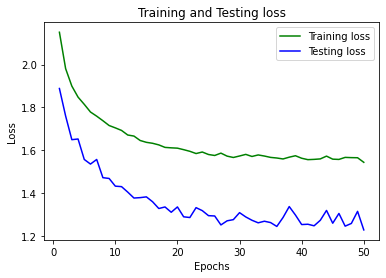

In [ ]:
show_loss_curves(trainer.logs)

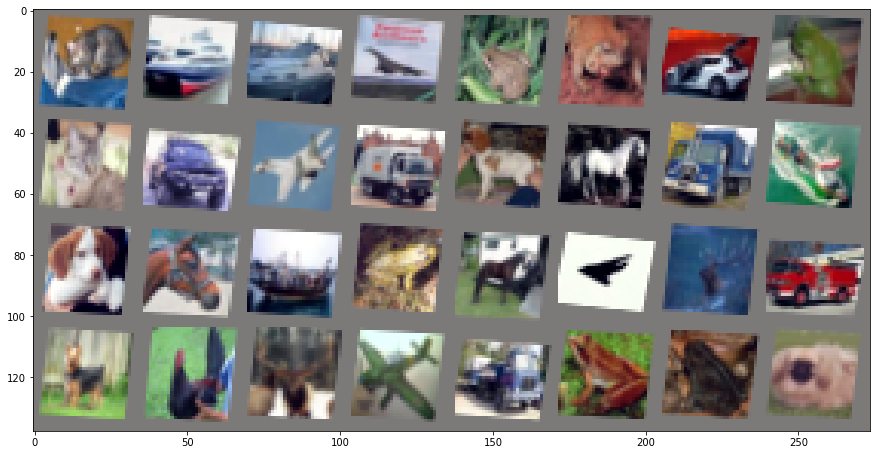

In [ ]:
plt.figure(figsize=(15, 10))
plt.imshow(trainer.stn_visuals[2])

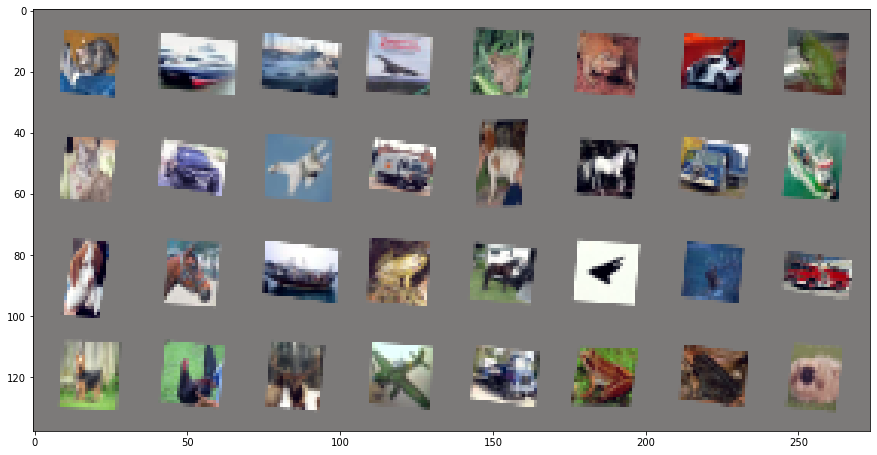

In [ ]:
plt.figure(figsize=(15, 10))
plt.imshow(trainer.stn_visuals[49])

In [ ]:
import imageio

In [ ]:
imageio.mimsave('./stn_cifar10.gif', trainer.stn_visuals)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0